# Mouse ESC datasets

## Imports

In [1]:
import glob
import pandas as pd
import numpy as np
import os
from IPython.display import HTML
import scipy
import torch
import pickle
import re
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from inspect import signature

In [2]:
from scvi.models import AutoZIVAE
from scvi.inference import UnsupervisedTrainer
from datasets.esc import KolodziejczykESCDataset
import torch
import pickle
import argparse
import re
import numpy as np
import time
from scvi.models.log_likelihood import compute_marginal_log_likelihood_scvi, compute_marginal_log_likelihood_autozi
import os
from autozi_simulate_tools import retrieve_rates_dropouts
from classification_metrics import *
from functools import partial

[2019-10-11 21:14:19,570] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/oscar/miniconda3/lib/python3.7/site-packages/scikit_learn-0.19.2-py3.7-linux-x86_64.egg/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
plt.switch_backend("TkAgg")
%matplotlib inline

## Train AutoZI on datasets

For each dataset under scrutiny, we retrieve the posterior parameters $\alpha^g, \beta^g$ of $q(\delta_g)$ for each gene $g$.

In [4]:
results_autozi_outputs = []
datasets_mapper = {
    'kolodc57-esc-004-025': partial(KolodziejczykESCDataset, fraction_genes=0.04, fraction_uz_genes_left=0.25),
   }

for dataset_name in datasets_mapper:
    data = datasets_mapper[dataset_name]()

    np.random.seed(int(time.time()))
    torch.manual_seed(int(time.time()))
    model = AutoZIVAE(n_input=data.nb_genes, alpha_prior=0.5, beta_prior=0.5,minimal_dropout=0.01)
    trainer = UnsupervisedTrainer(model, data)
    trainer.train(n_epochs=600, lr=1e-2)
    outputs = trainer.model.get_alphas_betas(as_numpy=True)
    outputs['dataset_name'] = dataset_name
    outputs['gene_labels'] = data.gene_labels
    outputs['means_emp'] = data.X.mean(axis=0)
    results_autozi_outputs.append(outputs)

[2019-10-11 21:14:23,639] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 21:14:23,640] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 600/600 [00:39<00:00, 15.15it/s]


## Compute metrics from AutoZI's outputs

For each dataset under scrutiny, from these $\alpha^g, \beta^g$, we estimate the ZI probabilities $q(\delta_g < 0.5)$ using tools from `classification_metrics.py`.

In [5]:
results_autozi_data_list = []

for outputs in results_autozi_outputs:
    

    model_score_evals = [
        AutoZIBernoulliThresholdEval('bernoullithreshold50', outputs, [], threshold=0.50),
    ]

    results_autozi_data = {}
    for model_score_eval in model_score_evals:
        # Just select the scores used to compute the metrics
        # Positives are ZI genes 
        results_autozi_data[model_score_eval.name] = model_score_eval.scores
        
    for key in ['gene_labels','means_emp','dataset_name']:
        results_autozi_data[key] = outputs.get(key,None)
        
    results_autozi_data_list.append(results_autozi_data)
    
results_autozi = pd.DataFrame(results_autozi_data_list)

In [6]:
results_autozi = results_autozi.sort_values(by=['dataset_name']).set_index(['dataset_name'])

## Show labelled genes in the space of kinetic parameters

In [7]:
def plot_esc_points(kons, koffs, labels_zinb, logs=True, title='Plot', save=False):
    
    fig = plt.figure()
    axes = plt.gca()
    
    if logs:
        kons = np.log10(kons)
        koffs = np.log10(koffs)
        
    for is_zinb_pred in [False,True]:
        color = 'red' if is_zinb_pred else 'green'
        label= 'Predicted ZINB genes' if is_zinb_pred else 'Predicted NB genes'
        plt.scatter(x=kons[labels_zinb == is_zinb_pred], y=koffs[labels_zinb == is_zinb_pred],\
                    label=label, color=color, alpha=0.7)
        
    vals_x = np.linspace(*axes.get_xlim())
    vals_x = vals_x[vals_x <= 0]
    vals_y = np.linspace(*axes.get_ylim())
    plt.plot(vals_x, np.zeros(vals_x.size), 'b-')
    plt.plot(np.zeros(vals_y.size), vals_y, 'b-')
    plt.xlabel('$\log_{10}(k_{on})$')
    plt.ylabel('$\log_{10}(k_{off})$')
    plt.legend(loc='upper left')
    
    if save:
        plt.savefig('file.png', dpi=400, transparent=True)
    
    plt.show()

Predictions for kolodc57-esc-004-025
Bimodal: 39 ZINB genes =>  0.75 of  52
UNZ: 38 NB genes =>  0.7450980392156863  of  51
UZ: 23 ZINB genes =>  0.7931034482758621  of  29
Plot in the space of kinetic parameters :


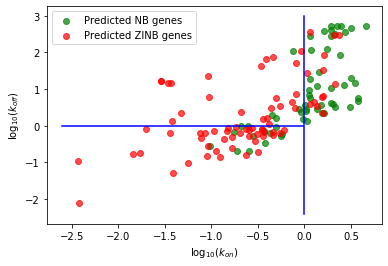

In [9]:
logs = True 

for dataset_name, gene_labels, means_emp, zi_probs   \
    in zip(results_autozi.index, results_autozi.gene_labels,\
           results_autozi.means_emp, results_autozi.bernoullithreshold50):
           
    koffs = gene_labels['koff_c57']
    kons = gene_labels['kon_c57']

    # Restrict on bimodal or UNZ genes with sufficient expression
    mask_means_emp = (means_emp > 1.)
    mask_b_unz = np.logical_and(~((kons < 1) & (koffs >= 1)), mask_means_emp)
    mask_uz = np.logical_and(((kons < 1) & (koffs >= 1)), mask_means_emp)

    is_bimod_gt = ((kons < 1) & (koffs < 1))[mask_b_unz]

    labels_zinb = (zi_probs > 0.5)
    print('Predictions for', dataset_name)
    print('Bimodal:', labels_zinb[mask_b_unz][is_bimod_gt].sum(), 'ZINB genes => ', labels_zinb[mask_b_unz][is_bimod_gt].mean(), 'of ', is_bimod_gt.sum())
    print('UNZ:', (~labels_zinb)[mask_b_unz][~is_bimod_gt].sum(), 'NB genes => ', (~labels_zinb)[mask_b_unz][~is_bimod_gt].mean(), ' of ', (~is_bimod_gt).sum())
    print('UZ:', (labels_zinb)[mask_uz].sum(), 'ZINB genes => ', (labels_zinb)[mask_uz].mean(), ' of ', mask_uz.sum())
    print('Plot in the space of kinetic parameters :')
    plot_esc_points(kons[mask_means_emp], koffs[mask_means_emp], labels_zinb[mask_means_emp], logs=logs)
